In [739]:
# import requests

# for i in range(3, 13):
#     i_str = str(i)
#     if i % 10 == i:
#         i_str = '0'+i_str
#     url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=MSFT&interval=60min&month=2020-{i_str}&outputsize=full&apikey=YTKU4MFI004OH7U9&datatype=csv'
#     r = requests.get(url, allow_redirects=True)
#     open(f'train_data/60min_MSFT_2020_{i_str}.csv', 'wb').write(r.content)

# for i in range(1, 13):
#     i_str = str(i)
#     if i % 10 == i:
#         i_str = '0'+i_str
#     url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=MSFT&interval=60min&month=2021-{i_str}&outputsize=full&apikey=YTKU4MFI004OH7U9&datatype=csv'
#     r = requests.get(url, allow_redirects=True)
#     open(f'train_data/60min_MSFT_2021_{i_str}.csv', 'wb').write(r.content)

# for i in range(1, 5):
#     i_str = str(i)
#     if i % 10 == i:
#         i_str = '0'+i_str
#     url = f'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=MSFT&interval=60min&month=2020-{i_str}&outputsize=full&apikey=2TU3VVSS2DD06FED&datatype=csv'
#     r = requests.get(url, allow_redirects=True)
#     open(f'train_data/60min_MSFT_2020_{i_str}.csv', 'wb').write(r.content)

<h2 style='text-align: center;'> Dependencies </h2>

In [771]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from vmdpy import VMD

In [819]:
frames = []
for y in range(2016, 2024):
    y_str = str(y)
    for i in range(1, 13):
        i_str = str(i)
        if i % 10 == i:
            i_str = '0'+i_str
        data = pd.read_csv(f'price_data/60min_MSFT_{y_str}_{i_str}.csv').iloc[::-1]
        data['timestamp'] = pd.to_datetime(data['timestamp'])
        data.set_index('timestamp', inplace=True)
        frames.append(data)

for i in range(1, 3):
    i_str = str(i)
    if i % 10 == i:
        i_str = '0'+i_str
    data = pd.read_csv(f'price_data/60min_MSFT_2024_{i_str}.csv').iloc[::-1]
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data.set_index('timestamp', inplace=True)
    frames.append(data)
stockprices = pd.concat(frames)
stockprices.index = stockprices.index.tz_localize('UTC')
stockprices['timestamp'] = pd.to_datetime(stockprices.index)
stockprices['date'] = stockprices.index.normalize()
stockprices.set_index('date', inplace=True)
stockprices

,open,high,low,close,volume,timestamp
date,,,,,,
2016-01-04 00:00:00+00:00,49.221,49.262,48.335,48.386,876,2016-01-04 04:00:00+00:00
2016-01-04 00:00:00+00:00,48.343,48.383,48.282,48.333,500,2016-01-04 06:00:00+00:00
2016-01-04 00:00:00+00:00,48.227,48.348,48.034,48.253,10819,2016-01-04 07:00:00+00:00
2016-01-04 00:00:00+00:00,48.307,48.569,48.034,48.342,30010,2016-01-04 08:00:00+00:00
2016-01-04 00:00:00+00:00,48.351,48.427,47.759,48.315,6275132,2016-01-04 09:00:00+00:00
...,...,...,...,...,...,...
2024-02-29 00:00:00+00:00,409.900,414.200,409.660,413.420,5649487,2024-02-29 15:00:00+00:00
2024-02-29 00:00:00+00:00,413.420,428.724,397.894,412.800,25685638,2024-02-29 16:00:00+00:00
2024-02-29 00:00:00+00:00,412.800,413.640,412.800,413.045,100266,2024-02-29 17:00:00+00:00


In [820]:
sentiments = pd.read_csv('aggr_data/sentiments_2016_to_2024.csv')
sentiments['timestamp'] = pd.to_datetime(sentiments['timestamp'])
sentiments.set_index('timestamp', inplace=True)

stockprices = stockprices.join(sentiments, how='left')
stockprices.set_index('timestamp', inplace=True)
stockprices.to_csv('aggr_data/stockprices.csv')

In [821]:
test_ratio = 0.35
train_ratio = 1 - test_ratio

train_size = int(train_ratio *len(stockprices))
test_size = int(test_ratio * len(stockprices))

train_data = stockprices[:train_size]
test_data = stockprices[train_size+50:]

<h2 style='text-align: center;'> Vector Mode Decomposition </h2>

In [822]:
alpha = 5000      # moderate bandwidth constraint  
tau = 0           # noise-tolerance (no strict fidelity enforcement)  
K = 5              # 5 modes  
DC = 0             # no DC part imposed  
init = 1           # initialize omegas uniformly  
tol = 1e-7

signals, u_hat, omega = VMD(stockprices['close'].to_numpy(), alpha, tau, K, DC, init, tol)

for i, signal in enumerate(signals):
    stockprices[f'signal{i}'] = signal

stockprices

,open,high,low,close,volume,sentiment_score,signal0,signal1,signal2,signal3,signal4
timestamp,,,,,,,,,,,
2016-01-04 04:00:00+00:00,49.221,49.262,48.335,48.386,876,0.212121,46.885372,1.557611,-0.311681,0.053245,-0.008897
2016-01-04 06:00:00+00:00,48.343,48.383,48.282,48.333,500,0.212121,46.883766,1.555220,-0.308763,0.043076,0.023267
2016-01-04 07:00:00+00:00,48.227,48.348,48.034,48.253,10819,0.212121,46.881024,1.550932,-0.302364,0.024435,-0.024284
2016-01-04 08:00:00+00:00,48.307,48.569,48.034,48.342,30010,0.212121,46.877271,1.544904,-0.292267,-0.000478,0.011745
2016-01-04 09:00:00+00:00,48.351,48.427,47.759,48.315,6275132,0.212121,46.871889,1.536552,-0.279012,-0.029553,0.009993
...,...,...,...,...,...,...,...,...,...,...,...
2024-02-29 15:00:00+00:00,409.900,414.200,409.660,413.420,5649487,0.149686,408.661043,-0.726812,2.598421,0.995435,0.051393
2024-02-29 16:00:00+00:00,413.420,428.724,397.894,412.800,25685638,0.149686,408.673760,-0.712448,2.725406,1.325791,-0.034131
2024-02-29 17:00:00+00:00,412.800,413.640,412.800,413.045,100266,0.149686,408.678814,-0.706265,2.816640,1.582750,0.019081


<h2 style='text-align: center;'> LSTM </h2>

In [764]:
def get_rmse(y_true, pred):
    return np.sqrt(np.mean((y_true - pred) ** 2))

def get_mape(y_true, pred):
    pred, y_true = np.array(pred), np.array(y_true)
    return np.mean(np.abs(y_true - pred) / y_true) * 100

In [765]:
def get_perf_metrics(train_size, var):
    rmse = get_rmse(
        np.array(stockprices[train_size:]["close"]),
        np.array(stockprices[train_size:][var]),
    )
    ### MAPE
    mape = get_mape(
        np.array(stockprices[train_size:]["close"]),
        np.array(stockprices[train_size:][var]),
    )
    return rmse, mape

In [766]:
def extract_x_y(data, N, offset, future_steps):
    X, y = [], []

    for i in range(offset, len(data) - future_steps + 1):
        X.append(data[i - N: i, 1:])
        y.append(data[i+future_steps-1, 0])
    return np.array(X), np.array(y)

In [767]:
layer_units = 400
optimize_func = 'adam'
curr_epochs = 15 # Should be 2000 according to the paper.
curr_batch_size = 20
window_size = 50
future_steps = 5

scaler = StandardScaler()
scaled_data = scaler.fit_transform(stockprices[['close', 'signal0', 'signal1', 'signal2', 'signal3', 'signal4']])
scaled_data_train = scaled_data[:train_data.shape[0]]
X_train, y_train = extract_x_y(scaled_data_train, window_size, window_size, future_steps)

In [749]:
def run_LSTM(X_train, layer_units):
    inp = tf.keras.layers.Input(shape=(X_train.shape[1], 5))
    x = tf.keras.layers.LSTM(units=layer_units, return_sequences=True)(inp)
    x = tf.keras.layers.LSTM(units=layer_units)(x)
    output = tf.keras.layers.Dense(1, activation='linear')(x)
    
    model = tf.keras.Model(inp,output)
    model.compile(loss='mean_squared_error', optimizer=optimize_func)

    return model

model = run_LSTM(X_train, layer_units)
history = model.fit(
    X_train,
    y_train,
    epochs=curr_epochs,
    batch_size=curr_batch_size,
    verbose=1,
    validation_split=0.1,
    shuffle=True,
)

Epoch 1/15
918/918 [==============================] - 111s 118ms/step - loss: 0.0051 - val_loss: 0.0027
Epoch 2/15
918/918 [==============================] - 104s 113ms/step - loss: 2.8998e-04 - val_loss: 3.0261e-04
Epoch 3/15
918/918 [==============================] - 103s 112ms/step - loss: 2.2522e-04 - val_loss: 7.5364e-04
Epoch 4/15
918/918 [==============================] - 102s 111ms/step - loss: 2.0652e-04 - val_loss: 0.0011
Epoch 5/15
918/918 [==============================] - 100s 109ms/step - loss: 1.8434e-04 - val_loss: 3.7116e-04
Epoch 6/15
918/918 [==============================] - 100s 109ms/step - loss: 1.9822e-04 - val_loss: 2.8180e-04
Epoch 7/15
918/918 [==============================] - 102s 111ms/step - loss: 1.7378e-04 - val_loss: 3.9689e-04
Epoch 8/15
918/918 [==============================] - 101s 110ms/step - loss: 1.3491e-04 - val_loss: 3.6271e-04
Epoch 9/15
918/918 [==============================] - 104s 113ms/step - loss: 1.7066e-04 - val_loss: 5.0356e-04
Epoc

In [823]:
def preprocess_data(data=stockprices, scaler=scaler, window_size=window_size, test=test_data):
    raw = data[['close','signal0', 'signal1', 'signal2', 'signal3', 'signal4']][len(data) - len(test) - window_size:].values
    raw = scaler.transform(raw)
    X_test = [raw[i-window_size:i, 1:] for i in range(window_size, raw.shape[0])]
    X_test = np.array(X_test)
    
    return X_test

X_test = preprocess_data()
predicted_price_ = model.predict(X_test)
# Post-processing to fit scaler expectations
full_dummy_features = np.zeros((predicted_price_.shape[0], 6))  # Create a dummy array with the same number of columns as the scaler expects
full_dummy_features[:, 0] = predicted_price_.ravel()  # Assuming 'close' is the first column
# Inverse transform
predicted_price = scaler.inverse_transform(full_dummy_features)[:, 0]  # Inverse transform and select only the 'close' column

test_data["Predictions_lstm"] = predicted_price
test_data.to_csv('aggr_data/all_data.csv')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


343/343 [==============================] - 15s 42ms/step


/var/folders/tr/bn04qlvn5kqbrym_jh0sh87c0000gn/T/ipykernel_53756/1299529936.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["Predictions_lstm"] = predicted_price


LSTM Model RMSE: 13.22
LSTM Model MAPE: 2.99%


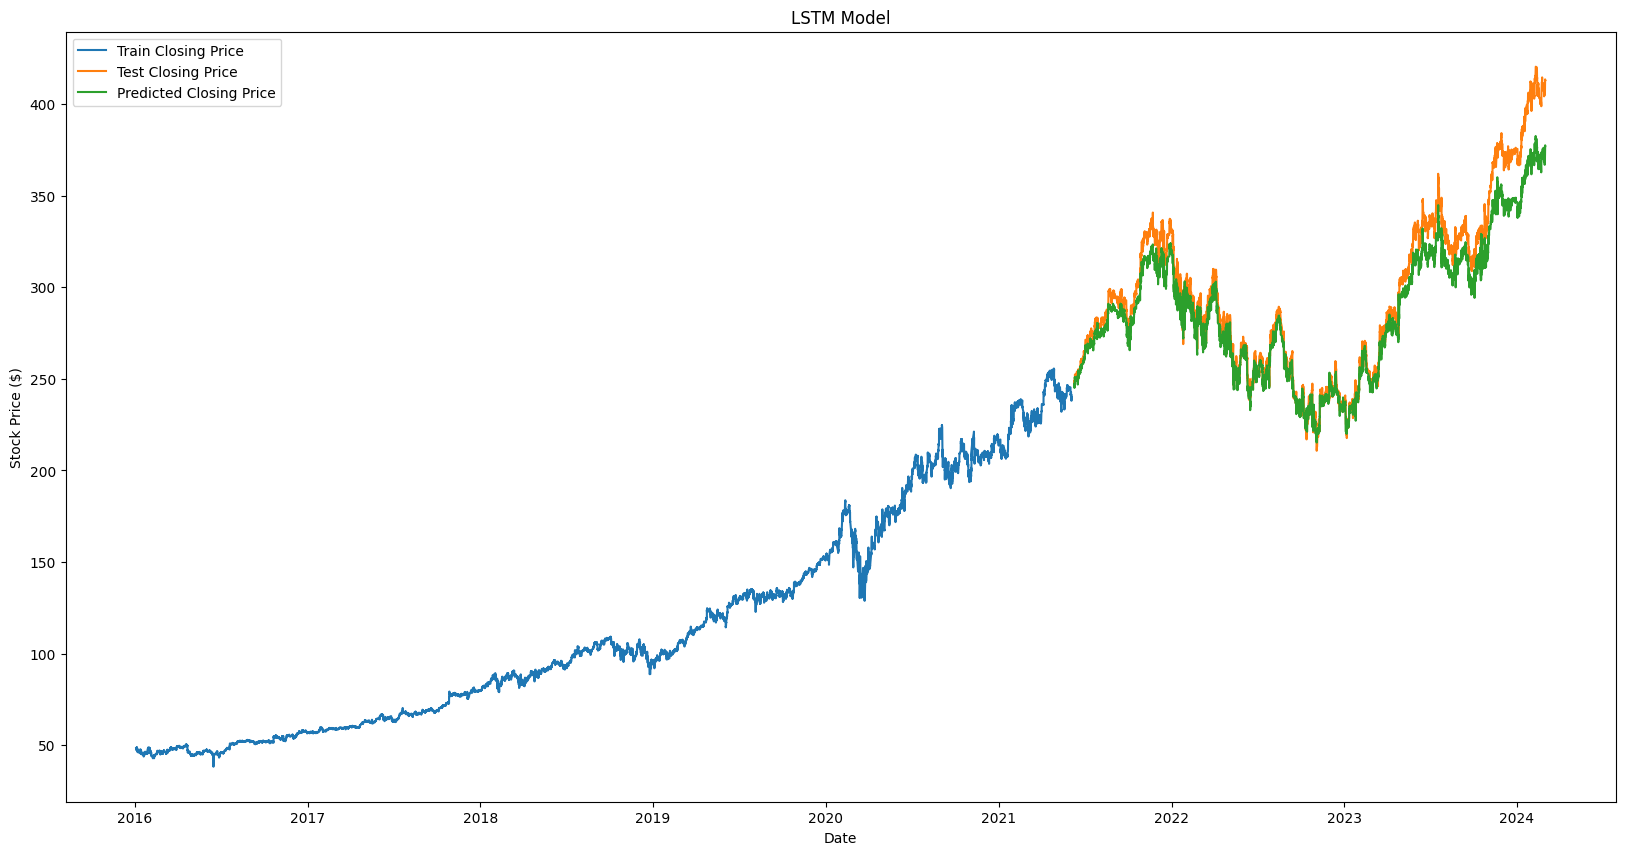

In [824]:
rmse_lstm = get_rmse(np.array(test_data.iloc[future_steps:, test_data.columns.get_loc("close")]), 
                     np.array(test_data.iloc[future_steps:, test_data.columns.get_loc("Predictions_lstm")]))
mape_lstm = get_mape(np.array(test_data.iloc[future_steps:, test_data.columns.get_loc("close")]), 
                     np.array(test_data.iloc[future_steps:, test_data.columns.get_loc("Predictions_lstm")]))
def plot_stock_trend_lstm(train, test):
    fig = plt.figure(figsize = (20,10))
    plt.plot(np.asarray(train.index), np.asarray(train["close"]), label = "Train Closing Price")
    plt.plot(np.asarray(test.index), np.asarray(test["close"]), label = "Test Closing Price")
    plt.plot(np.asarray(test.index), np.asarray(test["Predictions_lstm"]), label = "Predicted Closing Price")
    plt.title("LSTM Model")
    plt.xlabel("Date")
    plt.ylabel("Stock Price ($)")
    plt.legend(loc="upper left")

plot_stock_trend_lstm(train_data, test_data)

print(f"LSTM Model RMSE: {round(rmse_lstm, 2)}")
print(f"LSTM Model MAPE: {round(mape_lstm, 2)}%")

In [753]:
model.save('trained_models/LSTM_Price_Predictor_Trial.keras')